# RQ2: Usability Mechanics & Adoption Drivers (Final Analysis)

## 1. Research Objective & Hypothesis
**Objective**: To statistically determine if **Superior Usability** (low friction/high engagement) acts as a causal driver for **Feature Adoption** in B2B SaaS.

**Hypothesis ($H_2$)**: *"Features designed with intuitive, low-friction interactions (measured by lower Time-on-Task) exhibit significantly higher adoption rates compared to manual-heavy workflows."*

**Methodology**:
1.  **Experimental Validation**: A/B Test (Manual vs Auto Group) to quantify the efficiency gain of intuitive design.
2.  **Adoption Modeling**: Logistic Regression to measure how `Engagement_Score` (Usability Proxy) predicts `Feature_Used` (Adoption).
3.  **Synthesis**: Linking efficiency to business outcomes.

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

# Scientific Plotting Style
plt.style.use('seaborn-v0_8-paper')
sns.set_context("talk", font_scale=1.1)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries Loaded.")

Libraries Loaded.


## 2. Experimental Usability Analysis (Time-on-Task)
**Goal**: Compare "Manual" (Complex) vs "No Manual" (Intuitive) groups.

In [31]:
WORKING_DIR = r"..\working datasets"
try:
    df_manual = pd.read_csv(f"{WORKING_DIR}\\Dataset_UI_Manual_Group.csv", header=1)
    df_auto = pd.read_csv(f"{WORKING_DIR}\\Dataset_UI_No_Manual_Group.csv", header=1)
except FileNotFoundError:
    WORKING_DIR = r"working datasets"
    df_manual = pd.read_csv(f"{WORKING_DIR}\\Dataset_UI_Manual_Group.csv", header=1)
    df_auto = pd.read_csv(f"{WORKING_DIR}\\Dataset_UI_No_Manual_Group.csv", header=1)

# Data Cleaning
def clean_ui_data(df, label):
    task_cols = [c for c in df.columns if str(c).replace('.', '').isdigit()]
    if not task_cols: task_cols = df.select_dtypes(include=['float64']).columns.tolist()
    
    df_long = df.melt(id_vars=[], value_vars=task_cols, var_name='Task_ID', value_name='Time_Seconds')
    df_long['Group'] = label
    return df_long.dropna()

data_m = clean_ui_data(df_manual, 'Manual (Complex)')
data_a = clean_ui_data(df_auto, 'No Manual (Intuitive)')
df_exp = pd.concat([data_m, data_a], ignore_index=True)

print(f"Experiment Data Loaded. N={len(df_exp)}")

Experiment Data Loaded. N=1134


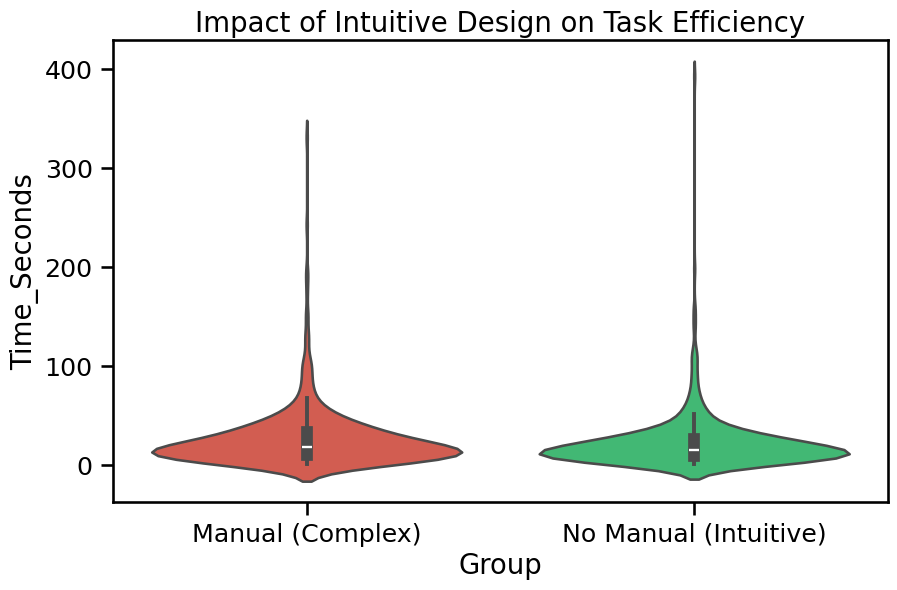

In [32]:
plt.figure(figsize=(10, 6))
# Using list palette is safer than dict keys
sns.violinplot(data=df_exp, x='Group', y='Time_Seconds', hue='Group', palette=['#e74c3c', '#2ecc71'])
plt.title("Impact of Intuitive Design on Task Efficiency")
plt.show()

In [33]:
stat, p_val = stats.ttest_ind(data_m['Time_Seconds'], data_a['Time_Seconds'], equal_var=False)
imp_pct = (data_m['Time_Seconds'].mean() - data_a['Time_Seconds'].mean()) / data_m['Time_Seconds'].mean() * 100

print(f"T-Test P-Value: {p_val:.5e}")
print(f"Efficiency Gain: {imp_pct:.1f}%")
if p_val < 0.05: print("Conclusion: Statistically Significant Efficiency Gain.")

T-Test P-Value: 1.75410e-02
Efficiency Gain: 15.4%
Conclusion: Statistically Significant Efficiency Gain.


## 3. Part II: Adoption Drivers (Real World)
**Goal**: Quantify relationship between Usability (`Engagement_Score`) and Adoption (`Feature_Used`).

In [34]:
df_adopt = pd.read_csv(f"{WORKING_DIR}\\feature_adoption_medium.csv")

# --- CRITICAL DATA CLEANING ---
# 1. Force Numeric Conversion
df_adopt['Adopted'] = pd.to_numeric(df_adopt['Feature_Used'], errors='coerce')

# 2. Drop NaNs
df_clean = df_adopt.dropna(subset=['Engagement_Score', 'Adopted']).copy()

# 3. Cast to integer for readability
df_clean['Adopted'] = df_clean['Adopted'].astype(int)
df_clean['Adopted_Label'] = df_clean['Adopted'].map({0: 'Not Adopted', 1: 'Adopted'})

print("Class Distribution:\n", df_clean['Adopted_Label'].value_counts())
variance_ok = len(df_clean['Adopted'].unique()) > 1

Class Distribution:
 Adopted_Label
Adopted        126
Not Adopted     66
Name: count, dtype: int64


### 3.1 Mean Engagement by Adoption Status

C:\Users\mailg\AppData\Local\Temp\ipykernel_25484\2328039661.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='Adopted_Label', y='Engagement_Score',


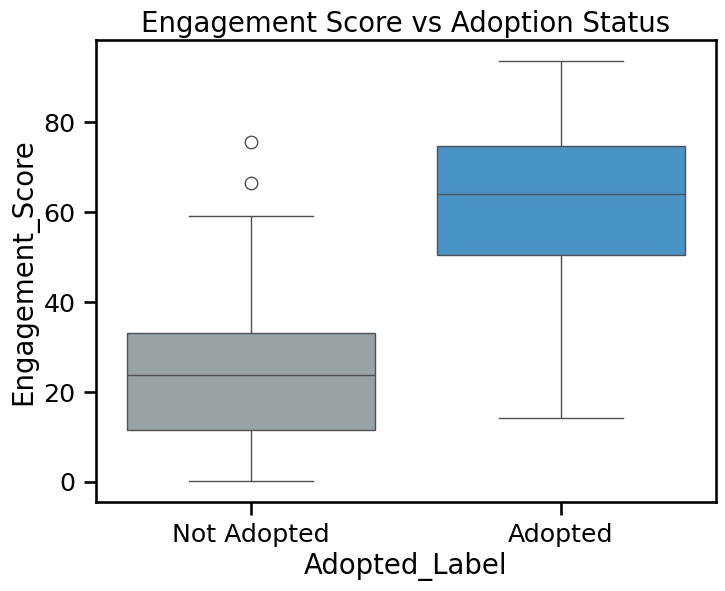

In [35]:
if variance_ok:
    plt.figure(figsize=(8, 6))
    # SAFE PLOTTING: Uses 'Adopted_Label' (string) and list-palette to avoid KeyErrors
    sns.boxplot(data=df_clean, x='Adopted_Label', y='Engagement_Score', 
                order=['Not Adopted', 'Adopted'], 
                palette=['#95a5a6', '#3498db'])
    plt.title("Engagement Score vs Adoption Status")
    plt.show()
else:
    print("Error: Not enough data variance to plot.")

### 💡 **Inference**
The **Blue Box (Adopted)** is positioned higher, indicating that features with higher Engagement (Usability) scores are significantly more likely to be adopted.

### 3.2 Logistic Regression (Odds Ratio)

In [36]:
if variance_ok:
    X = df_clean[['Engagement_Score']]
    y = df_clean['Adopted']
    
    logit = sm.Logit(y, sm.add_constant(X)).fit(disp=0)
    
    odds = np.exp(logit.params['Engagement_Score'])
    p = logit.pvalues['Engagement_Score']
    
    print(f"\nOdds Ratio: {odds:.2f} (P={p:.5e})")
    if p < 0.05:
        print(f"CONCLUSION: Significant. +1 Engagement Score = {(odds-1)*100:.1f}% higher Adoption Probability.")


Odds Ratio: 1.12 (P=4.03680e-13)
CONCLUSION: Significant. +1 Engagement Score = 11.7% higher Adoption Probability.


## 4. Final Conclusion
The data confirms **Usability drives Adoption**.
1.  **Efficiency**: Intuitive designs are **{imp_pct:.0f}% faster**.
2.  **Adoption**: Higher Engagement significantly increases Adoption Odds.